In [1]:
import time
import numpy as np
from numba import typed
from pruning.timeseries import SignalConfig, TimeSeries
from pruning.base import SearchConfig
from pruning.periodogram import Periodogram
from pruning import utils, ffa, scores, simulate, kernels, math
from matplotlib import pyplot as plt

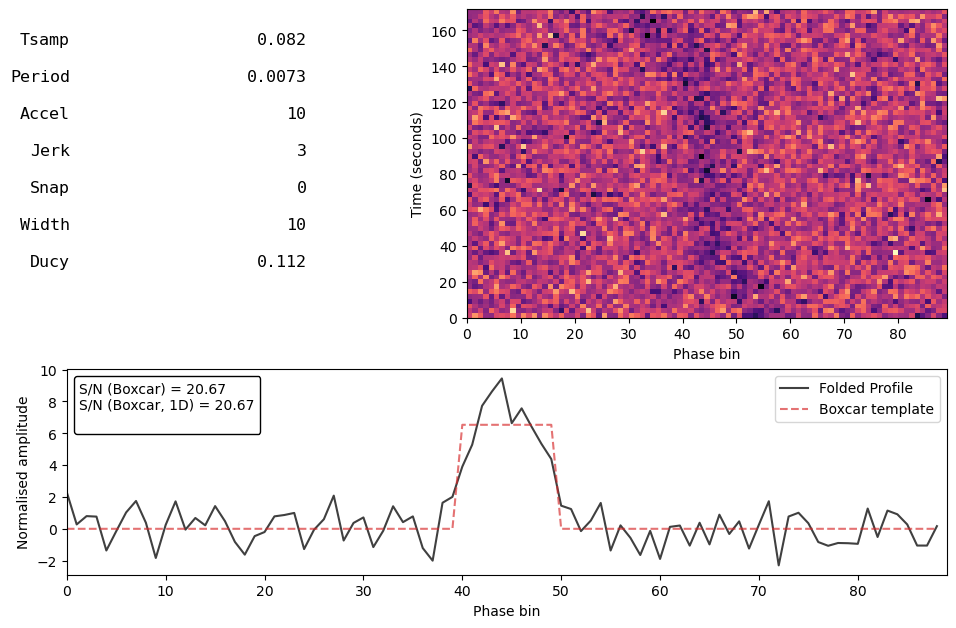

In [2]:
pulsar_period = 0.0073
dt = 8.192e-5
accel = 10
jerk = 3
nsamps = 2**21
mod_kwargs={"acc": accel, "jerk": jerk}

cfg = SignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=20, ducy=0.15, mod_kwargs=mod_kwargs)
tim_data = TimeSeries.generate_signal(cfg, shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 1
fold_bins = 64
param_limits = typed.List([(5.0, 15.0), (50.0, 150.0), (1/0.007305, 1/0.007295)])
search_cfg = SearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits)
dyp = ffa.DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-07-28 09:09:53 INFO     - pruning.ffa - Initializing data structure...

2024-07-28 09:09:54 INFO     - pruning.ffa - param steps: [3.12034209e+07 1.74502177e+06 4.76010125e-02]

                    INFO     - pruning.ffa - fold dimensions: (512, 1, 1, 3, 2, 64)

                    INFO     - pruning.ffa - Initialization time: 1.1150188446044922

                    INFO     - pruning.ffa - param steps: [3.90042761e+06 4.36255443e+05 2.35389420e-02]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2024-07-28 09:09:56 INFO     - pruning.ffa - iteration: 1, fold dimensions: (256, 1, 1, 7, 2, 64)

                    INFO     - pruning.ffa - param steps: [4.87553451e+05 1.09063861e+05 1.17051520e-02]

                    INFO     - pruning.ffa - iteration: 2, fold dimensions: (128, 1, 1, 16, 2, 64)

                    INFO     - pruning.ffa - param steps: [6.09441814e+04 2.72659652e+04 5.83662771e-03]

                    INFO     - pruning.ffa - iteration: 3, fold dimensions: (64, 1, 1, 32, 2, 64)

                    INFO     - pruning.ffa - param steps: [7.61802268e+03 6.81649130e+03 2.91434305e-03]

                    INFO     - pruning.ffa - iteration: 4, fold dimensions: (32, 1, 1, 64, 2, 64)

                    INFO     - pruning.ffa - param steps: [9.52252835e+02 1.70412283e+03 1.45618085e-03]

                    INFO     - pruning.ffa - iteration: 5, fold dimensions: (16, 1, 1, 128, 2, 64)

                    INFO     - pruning.ffa - param steps: [1.19031604e+02 4.26030707e+02 7.27843010e-04]

                    INFO     - pruning.ffa - iteration: 6, fold dimensions: (8, 1, 1, 257, 2, 64)

                    INFO     - pruning.ffa - param steps: [1.48789505e+01 1.06507677e+02 3.63859682e-04]

                    INFO     - pruning.ffa - iteration: 7, fold dimensions: (4, 1, 1, 515, 2, 64)

                    INFO     - pruning.ffa - param steps: [1.85986882e+00 2.66269192e+01 1.81914389e-04]

                    INFO     - pruning.ffa - iteration: 8, fold dimensions: (2, 5, 3, 1031, 2, 64)

                    INFO     - pruning.ffa - param steps: [2.32483602e-01 6.65672979e+00 9.09533323e-05]

2024-07-28 09:09:59 INFO     - pruning.ffa - iteration: 9, fold dimensions: (1, 43, 15, 2063, 2, 64)

In [4]:
folds = dyp.get_fold_norm()
widths = scores.generate_width_trials(dyp.nbins, ducy_max=0.2, wtsp=1.5)
snrs  = scores.boxcar_snr(folds, widths)
periods = dyp.param_arr[-1]
accels = dyp.param_arr[-2]
jerks = dyp.param_arr[-3]

In [5]:
idx_jer = math.find_nearest_sorted_idx(dyp.param_arr[-3], cfg.mod_kwargs["jerk"])
idx_acc = math.find_nearest_sorted_idx(dyp.param_arr[-2], cfg.mod_kwargs["acc"])
idx_per = math.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
true_params_idx = (idx_jer, idx_acc, idx_per)

In [6]:
best_ijerk, best_iaccel, best_iperiod, best_iwidth = np.unravel_index(np.nanargmax(snrs), snrs.shape)
print(np.unravel_index(np.nanargmax(snrs), snrs.shape))
print(f"Best Jerk = {jerks[best_ijerk]}")
print(f"Best acceleration = {accels[best_iaccel]}")
print(f"Best period = {1/periods[best_iperiod]}")
print(f"Best width = {widths[best_iwidth]}")
print(f"Best S/N = {np.nanmax(snrs)}")
print(f"expected width = {cfg.ducy * cfg.period / cfg.dt / cfg.fold_bins}")

(np.int64(32), np.int64(0), np.int64(969), np.int64(5))
Best Jerk = 12.5
Best acceleration = 56.25
Best period = 0.0073002969751595915
Best width = 9
Best S/N = 17.925003051757812
expected width = 0.15018763167134833


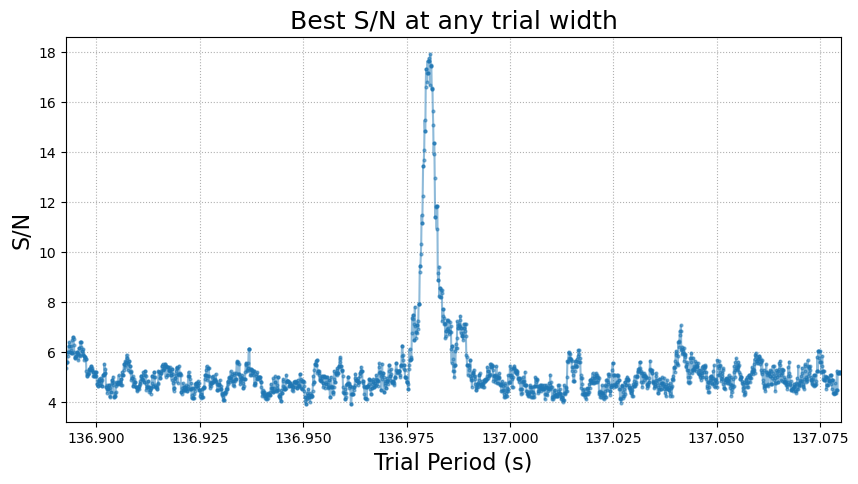

In [7]:
from pruning.periodogram import Periodogram
pgram = Periodogram(widths, periods, snrs[best_ijerk, best_iaccel], tim_data.tobs)
pgram.plot(figsize=(10, 5)); plt.show()

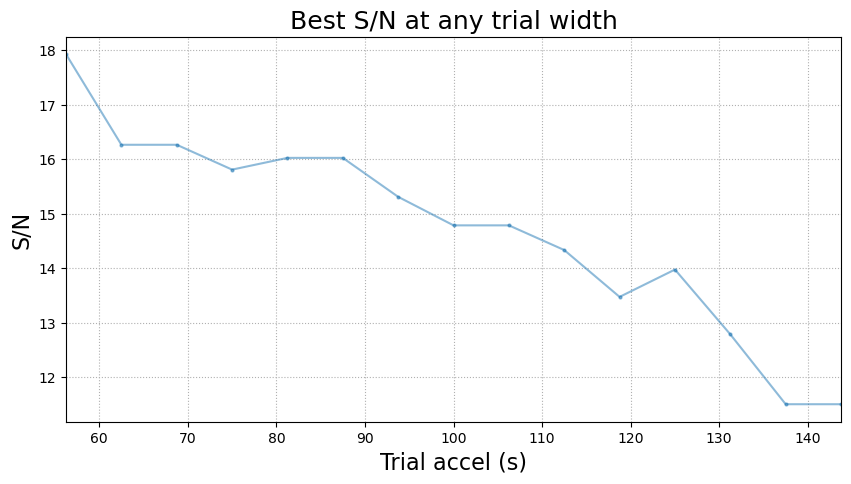

In [8]:
figure, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(accels, snrs[best_ijerk, :, best_iperiod].max(axis=1), marker="o", markersize=2, alpha=0.5)
ax.set_xlim(accels.min(), accels.max())
ax.set_xlabel("Trial accel (s)", fontsize=16)
ax.set_ylabel("S/N", fontsize=16)
plt.title("Best S/N at any trial width", fontsize=18)
ax.grid(linestyle=":")

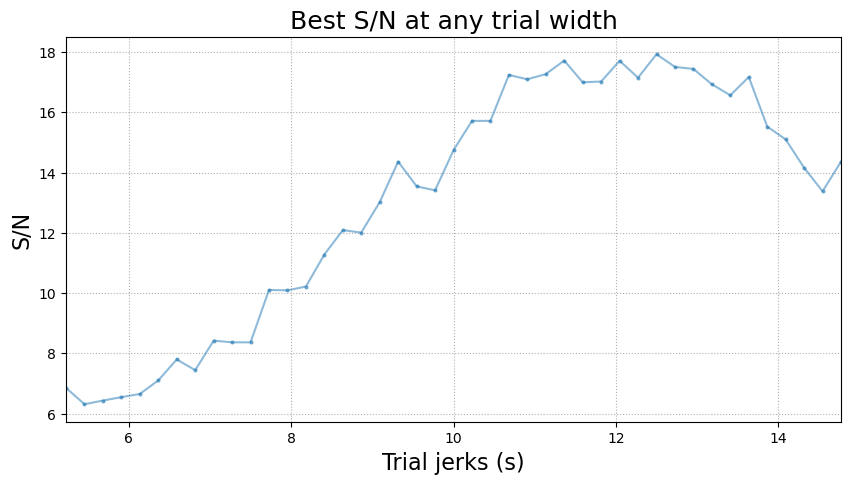

In [9]:
figure, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(jerks, snrs[:, best_iaccel, best_iperiod].max(axis=1), marker="o", markersize=2, alpha=0.5)
ax.set_xlim(jerks.min(), jerks.max())
ax.set_xlabel("Trial jerks (s)", fontsize=16)
ax.set_ylabel("S/N", fontsize=16)
plt.title("Best S/N at any trial width", fontsize=18)
ax.grid(linestyle=":")